# Test data process (xyz + uv + normal)

In [3]:
import os
import sys

sys.path.insert(0, os.path.abspath('..'))

from data_process.geometry_utils.obj import read_obj

mesh_fp = '../resources/examples/0000/0000.obj'
mesh_obj = read_obj(mesh_fp)

print('*** verts: ', mesh_obj.points.shape, mesh_obj.points.max(axis=0), mesh_obj.points.min(axis=0))
print('*** uvs: ', mesh_obj.point_data['obj:vt'].shape, mesh_obj.point_data['obj:vt'].max(axis=0), mesh_obj.point_data['obj:vt'].min(axis=0))
print('*** normals: ', mesh_obj.point_data['obj:vn'].shape, mesh_obj.point_data['obj:vn'].max(axis=0), mesh_obj.point_data['obj:vn'].min(axis=0))


*** verts:  (143000, 3) [ 459.852 1550.2    229.994] [-458.214  103.119 -196.118]
*** uvs:  (143000, 3) [1431.89 1762.71    0.  ] [-2.96054e+03  2.90294e+02 -5.01000e-06]
*** normals:  (143000, 3) [0.999997 0.998641 0.999999] [-0.999998 -0.999894 -1.      ]


dict_keys(['surf_wcs', 'edge_wcs', 'surf_ncs', 'edge_ncs', 'corner_wcs', 'global_offset', 'global_scale', 'surf_uv_wcs', 'edge_uv_wcs', 'surf_uv_ncs', 'edge_uv_ncs', 'corner_uv_wcs', 'uv_offset', 'uv_scale', 'surf_normals', 'edge_normals', 'corner_normals', 'faceEdge_adj'])
(10, 64, 64, 3) [0.00709596 0.07363456 0.01471971] 1.0670168
(69, 64, 3)
[_to_o3d_pc] color:  std::vector<Eigen::Vector3d> with 40960 elements.
Use numpy.asarray() to access data.
[_to_o3d_pc] color:  std::vector<Eigen::Vector3d> with 4416 elements.
Use numpy.asarray() to access data.


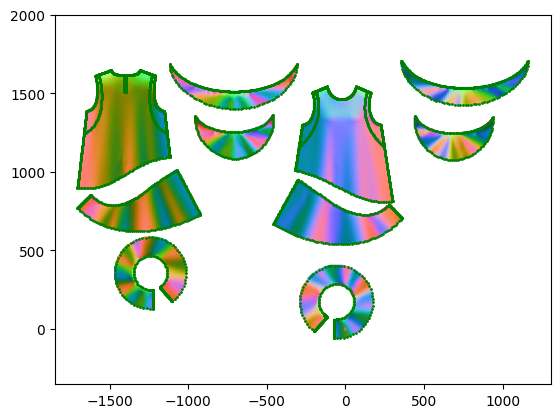

In [43]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt

def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd

def _denormalize_pnts(pnt_wcs, offset, scale):
    return pnt_wcs * scale * 0.5 + offset
    
data_path = "E:\\lry\\data\\AIGP\\demo_v2\\Q1\\brep_with_norm\\0000.pkl"

with open(data_path, "rb") as tf: data = pickle.load(tf)

print(data.keys())
print(data['surf_wcs'].shape, data['global_offset'], data['global_scale'])
print(data['edge_wcs'].shape)

global_offset = np.array(data['global_offset'])[None]
global_scale = data['global_scale']

uv_offset = data['uv_offset'][None]
uv_scale = data['uv_scale']

surf_pnts = data['surf_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset
edge_pnts = data['edge_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset

surf_uv = data['surf_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset
edge_uv = data['edge_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset

surf_pcd = _to_o3d_pc(surf_pnts, (data['surf_normals'].reshape(-1, 3) + 1)*0.5)
edge_pcd = _to_o3d_pc(edge_pnts, (0, 0, 0))

plt.scatter(surf_uv[:, 0], surf_uv[:, 1], c=(data['surf_normals'].reshape(-1, 3) + 1)*0.5, s=1)
plt.scatter(edge_uv[:, 0], edge_uv[:, 1], c='g', s=1)

# plt.axis('off')
plt.axis('equal')
plt.show()

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0., 0., 0.])
o3d.visualization.draw_geometries([surf_pcd, edge_pcd, mesh_frame])

